In [4]:
                                                       #ASSIGNMNET 2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [5]:
X = np.load("rolling_window_sequences.npy")
metadata = pd.read_csv("sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values

min_len = min(X.shape[0], len(y))
X = X[:min_len]
y = y[:min_len]


In [6]:
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
y = np.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)


In [7]:
X_shape = X.shape
X = X.reshape(-1, X_shape[2])
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = X.reshape(X_shape)

if y.max() != 0:
    y = y / y.max()


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)


Train shape: (14104, 30, 66) (14104,)
Val shape: (3527, 30, 66) (3527,)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)


In [10]:
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          33,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)
model_ckpt = ModelCheckpoint("best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1)


In [12]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)


Epoch 1/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1151
Epoch 1: val_loss improved from None to 0.11182, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - loss: 0.1128 - val_loss: 0.1118 - learning_rate: 1.0000e-04
Epoch 2/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1095
Epoch 2: val_loss improved from 0.11182 to 0.10949, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1095 - val_loss: 0.1095 - learning_rate: 1.0000e-04
Epoch 3/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1071
Epoch 3: val_loss improved from 0.10949 to 0.10712, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.1071 - val_loss: 0.1071 - learning_rate: 1.0000e-04
Epoch 4/50
220/221 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1051
Epoch 4: val_loss improved from 0.10712 to 0.10598, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.1054 -

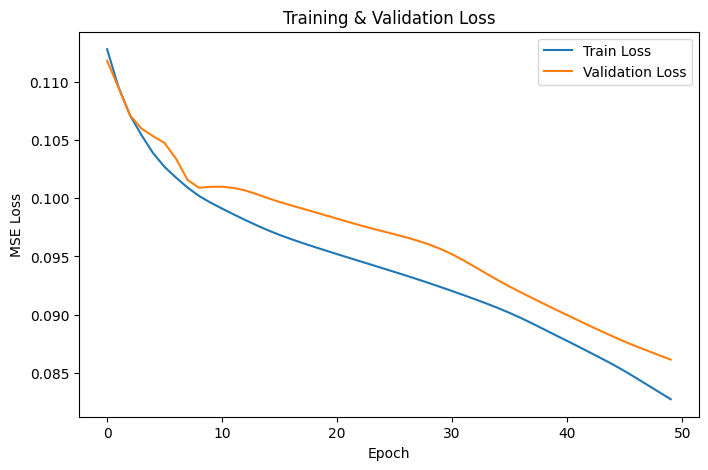

In [13]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()
